# Nonlinear buckling analysis of a box beam

***

In this notebook we apply MSC Nastran SOL 106's nonlinear buckling method to a cantilever box beam under different load conditions.

* [Geometry and material properties](#properties)
* [Setup of the numerical model](#numerical-model)
* [Uniform load over the top skin](#uniform-load)
    * [Mesh convergence study](#mesh-convergence)
    * [Nonlinear buckling method](#disrtibuted-load-flexible-tip)
        * [Rigid tip section](#distributed-load-rigid-tip)
    * [Concentrated load at the tip](#concentrated-load)
        * [Free tip section](#concentrated-load-flexible-tip)
        * [Rigid tip section](#concentrated-load-rigid-tip)

## Geometry and material properties <a name="properties"></a>

***

We consider an untapered cantilever thin-walled box beam with no internal reinforcement, as shown below.

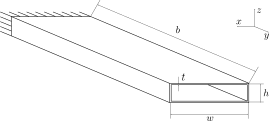

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

Notice how the width $w$ and the height $h$ are measured from the thin walls' midplane. This is done to be consistent with our numerical model, where we will use shell elements with a thickness developing simmetrically from the plane of the elements.

We define the geometric properties of our box beam with the aim of obtaining a scaled imitation of the Common Research Model (CRM, [Vassberg et al. 2008](https://arc.aiaa.org/doi/abs/10.2514/6.2008-6919)). For this reason we use an aspect ratio $2b/w=9$. The non-dimensional height is set to $h/w=0.28$ to represent the average height of the root wingbox section of the undeflected Common Research Model ([Brooks et al. 2018](https://arc.aiaa.org/doi/10.2514/1.J056603)), which is inferred from the data published by [Taylor & Hunsaker (2021)](https://arc.aiaa.org/doi/10.2514/6.2021-1591). For the wall thickness $t$ we use a $1/100$ ratio with respect to the height of the cross-section, in order to obtain a thin-walled structure. The width $w$ is set to $1$ m and the other dimensions follow from that.

In [2]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.28  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/100  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.28 m
- wall thickness: 2.80 mm


Next we define the material properties of our box beam. We use the same values employed by ([Brooks et al. 2018](https://arc.aiaa.org/doi/10.2514/1.J056603)) for the uCRM.

In [3]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

The first step to set up our numerical model consists in discretizing our geometry into quadrilateral shell elements. For this purpose we are going to use the `mesh_box` function from the `box_beam_utils` module. The function takes as input:
 - dimensions of the box;
 - prescribed edge length of the shell elements;

and it returns:
 - array with the xyz coordinates of the nodes;
 - array with their connectivity information.

Next we need to create a base Nastran input including material properties, element properties, nodes, CQUAD4 elements, boundary conditions and some default options to set up the output files. We'll do this using the `create_base_bdf_input` function from the `box_beam_utils` module. This function takes as input:
 - material properties;
 - wall thickness;
 - arrays obtained from the `mesh_box` function.

It returns a `BDF` object including the following cards:
 - MAT1 to define an isotropic material;
 - PSHELL to define the properties of the shell elements;
 - GRID and CQUAD4 to define nodes and quadrilateral shell elements, respectively;
 - SPC1 to define the boundary conditions, corresponding to clamped nodes along the root section of the box beam;
 - PARAM cards and case control commands to set up the output files.

For illustration purposes, let's create a bdf input with a shell element edge length of 100 mm and let's print the cards included in it.

In [4]:
from resources import box_beam_utils  # module with useful function for box beam problems

# Discretize geometry
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=100)
# Create BDF object
example_box_beam_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Print cards of BDF object
print(example_box_beam_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]
  SPC1:    1

bdf.params
  PARAM    : 1

bdf.nodes
  GRID     : 1316

bdf.elements
  CQUAD4   : 1288

bdf.properties
  PSHELL   : 1

bdf.materials
  MAT1     : 1




subcase=0 already exists...skipping


## Uniform load over the top skin <a name="uniform-load"></a>

***

The first loading condition that we consider is a uniformly distributed load $P$ over the top skin, as shown below. This is meant to represent a surrogate of the aerodynamic load.

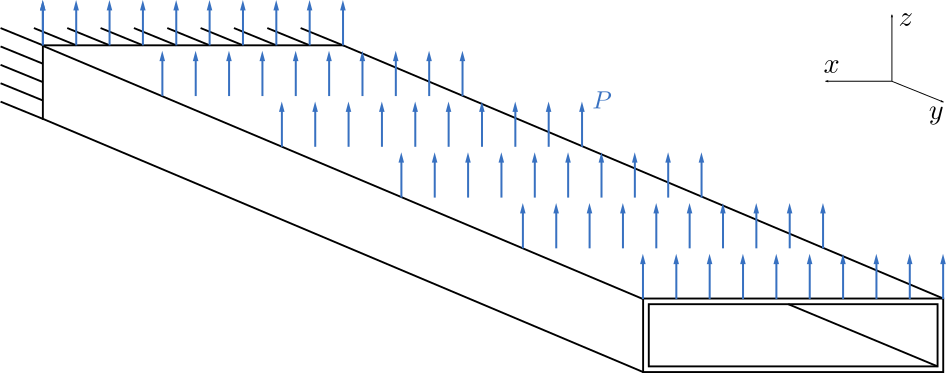

In [5]:
SVG(filename=os.path.join('resources', '04_BoxBeamUniformLoad.svg'))

We define the function `apply_uniform_load` to apply the mentioned load. This function applies a small force along the $z$ axis to every node of the top skin adding FORCE cards to the bdf input, in such a way that the total applied load is 1 N. This will allow us to easily scale the magnitude of the total applied load in our analyses.

In [6]:
import numpy as np  # library for working with arrays and linear algebra

# Define FORCE card id
force_set_id = 11

def apply_distributed_load(bdf_object, nodes_xyz_array):
    # Find ids of top skin nodes
    nodes_ids = np.arange(1, np.size(nodes_xyz_array, 0) + 1)  # all nodes' ids
    top_skin_nodes_ids = nodes_ids[nodes_xyz_array[:,2]==h/2]  # top skin nodes' ids
    # Define magnitude and direction of the force cards
    force_magnitude = 1/top_skin_nodes_ids.size
    force_direction = [0., 0., 1.]
    # Add a force card for each node of the top skin
    for node_id in top_skin_nodes_ids:
        bdf_object.add_force(sid=force_set_id, node=node_id, mag=force_magnitude, xyz=force_direction)

### Mesh convergence study <a name="mesh-convergence"></a>

In order to use a proper mesh size for our analyses, we need to perform a mesh convergence study. Since we want to study the buckling behavior of the box beam, we assess the convergence of the mesh monitoring the linear buckling load predicted by SOL 105 as the mesh is refined. For this purpose we are going to use the `calculate_linear_buckling_load` function from the `box_beam_utils` module, that calculates the linear buckling load taking as input a `BDF` object. This functions performs the following steps:
- assign solution sequence 105 to the input `BDF` object;
- create the first subcase for the application of the static load (`apply_uniform_load` has to be called before `calculate_linear_buckling_load` and the id of the load set to be applied has to be given as input);
- add an `EIGRL` card to define the parameters for the eigenvalue calculation and create the second subcase for the calculation of the buckling load;
- write the input file and run the analysis;
- read the results in the op2 file and return the buckling load;
- the function also plots the first buckling shape if the input variable `plot_shape` is set to `True`.

Let's calculate the linear buckling load and plot the corresponding shape for the example model created earlier.

Buckling load: 944 N
Buckling mode:


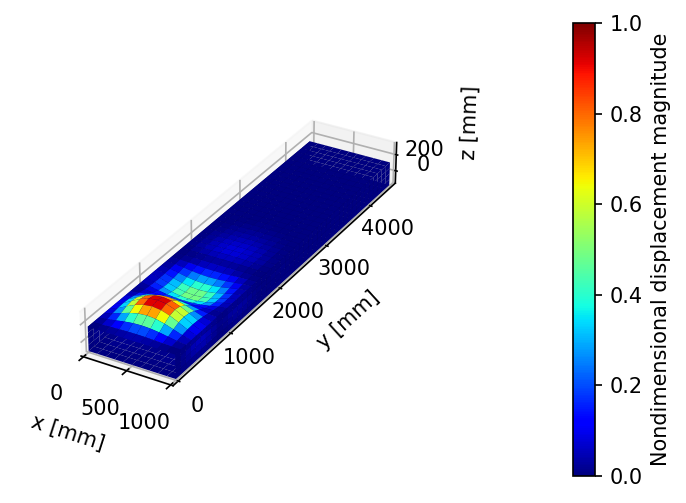

In [7]:
import matplotlib.pyplot as plt  # plotting library
%matplotlib inline

# Define name of analysis directory
analysis_directory_name = '04_Nonlinear_Buckling_Box_Beam'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Apply uniform load to example bdf input
apply_distributed_load(example_box_beam_input, nodes_coordinates_array)
# Calculate linear buckling load and plot buckling shape
plt.rcParams['figure.dpi'] = 150 # set default dpi of figures
linear_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=example_box_beam_input, static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='linear_buckling_example', run_flag=False, plot_shape=True)

Now we can run our mesh convergence study. We define 10 different linear sizes of the shell elements, evenly spaced on a log scale between the height of the box beam and double the thickness of the elements. For each shell element size we calculate the linear buckling load and we store the value, together with the number of degrees of freedom of the model.

Prescribed linear size of shell elements for mesh convergence study [mm]:
[280.  200.7 143.9 103.2  73.9  53.   38.   27.2  19.5  14. ]

Results for model with:
- 1296 degrees of freedom
- 216 elements
- 280.0 mm shell element edge length


subcase=0 already exists...skipping


Buckling load: 2131 N
Buckling mode:


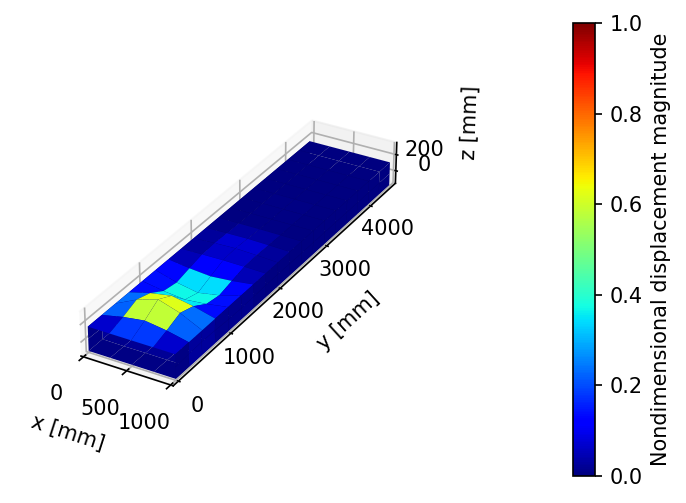


Results for model with:
- 2304 degrees of freedom
- 384 elements
- 200.7 mm shell element edge length


subcase=0 already exists...skipping


Buckling load: 1970 N
Buckling mode:


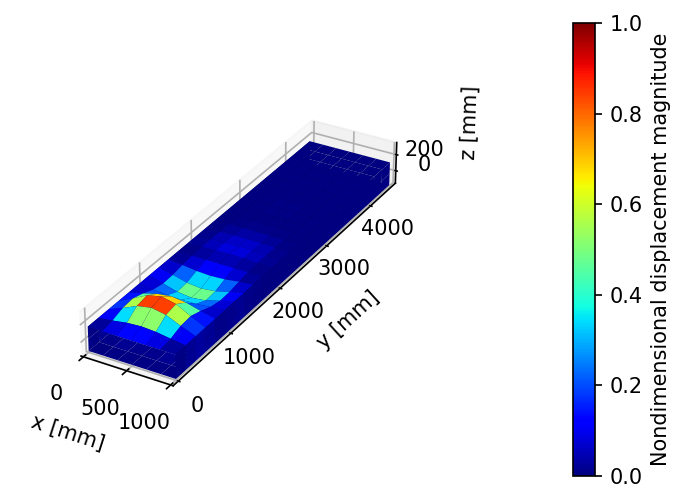


Results for model with:
- 3840 degrees of freedom
- 640 elements
- 143.9 mm shell element edge length


subcase=0 already exists...skipping


Buckling load: 1916 N
Buckling mode:


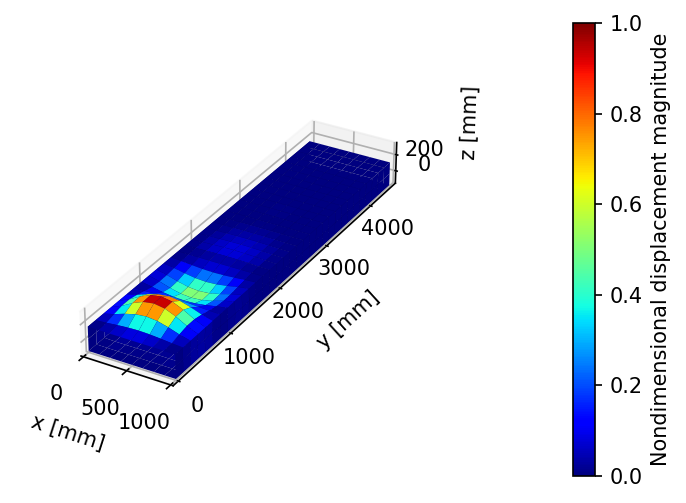


Results for model with:
- 7392 degrees of freedom
- 1232 elements
- 103.2 mm shell element edge length


subcase=0 already exists...skipping


Buckling load: 1890 N
Buckling mode:


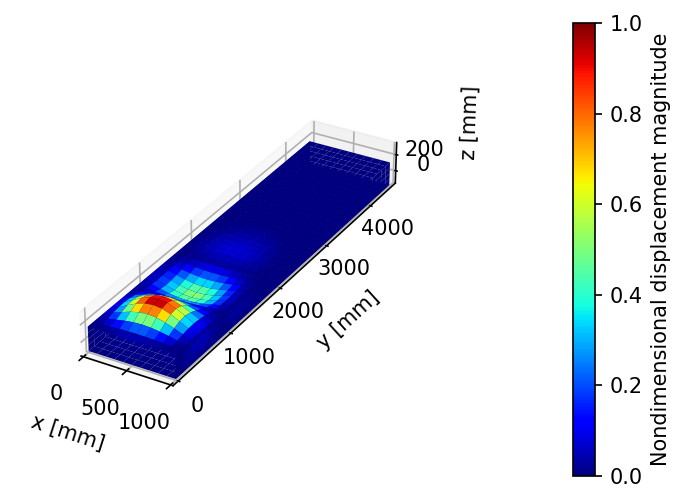


Results for model with:
- 13392 degrees of freedom
- 2232 elements
- 73.9 mm shell element edge length


subcase=0 already exists...skipping


Buckling load: 1880 N
Buckling mode:


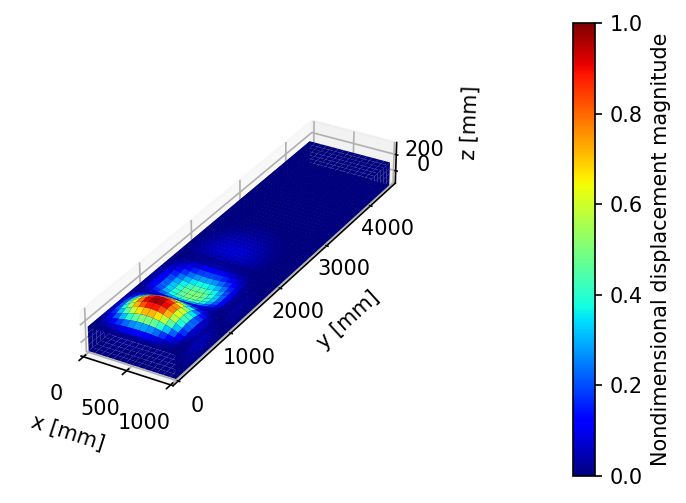


Results for model with:
- 26832 degrees of freedom
- 4472 elements
- 53.0 mm shell element edge length


subcase=0 already exists...skipping


Buckling load: 1879 N
Buckling mode:


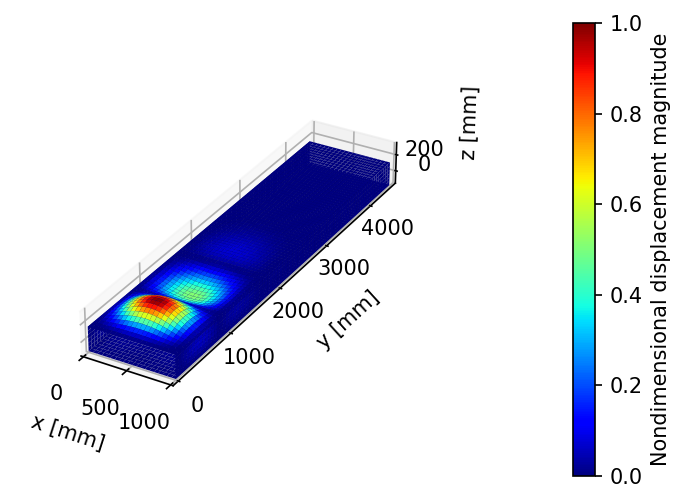

subcase=0 already exists...skipping



Results for model with:
- 51840 degrees of freedom
- 8640 elements
- 38.0 mm shell element edge length


Buckling load: 1881 N
Buckling mode:


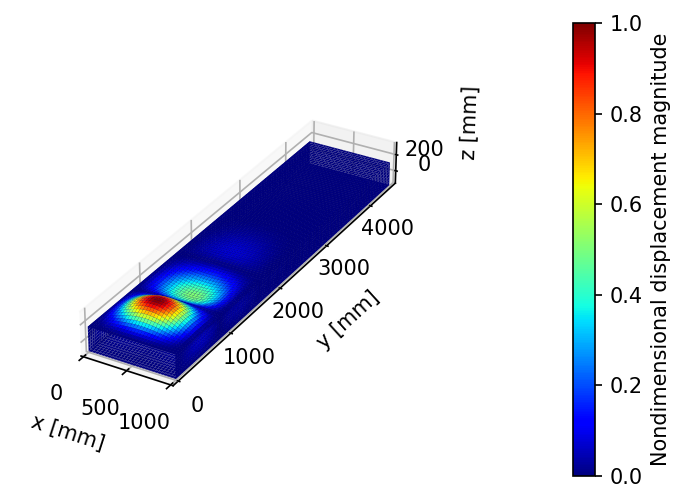

subcase=0 already exists...skipping



Results for model with:
- 99600 degrees of freedom
- 16600 elements
- 27.2 mm shell element edge length


Buckling load: 1882 N
Buckling mode:


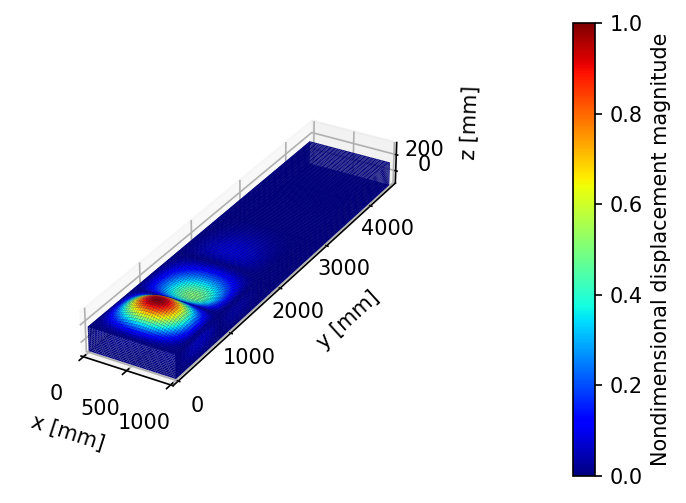

subcase=0 already exists...skipping



Results for model with:
- 189312 degrees of freedom
- 31552 elements
- 19.5 mm shell element edge length


Buckling load: 1884 N
Buckling mode:


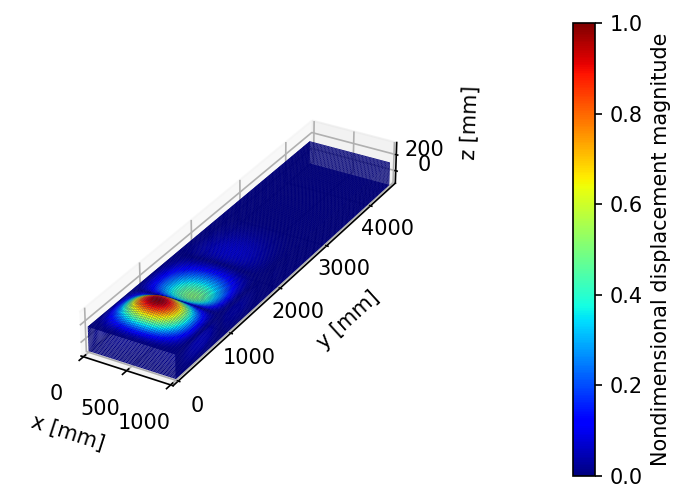

subcase=0 already exists...skipping



Results for model with:
- 355488 degrees of freedom
- 59248 elements
- 14.0 mm shell element edge length


Buckling load: 1884 N
Buckling mode:


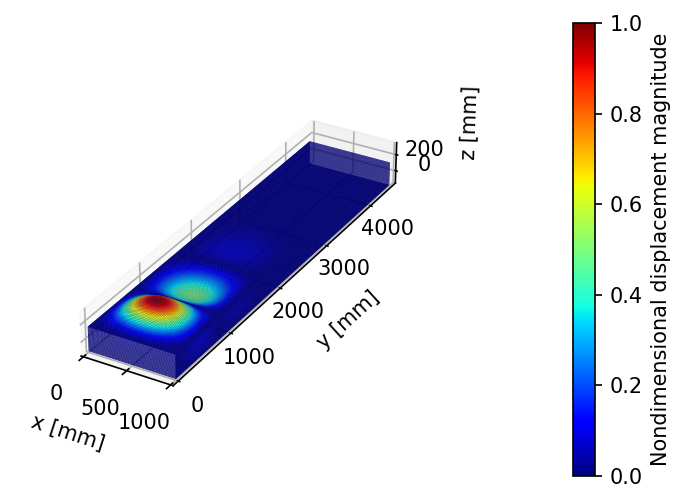

In [8]:
# Define edge lengths of the shell elements to be used for the mesh convergence study
shell_element_edges = np.geomspace(h, t*5, 10) # [mm]
print('Prescribed linear size of shell elements for mesh convergence study [mm]:')
np.set_printoptions(precision=1)
print(shell_element_edges)
# Initialize arrays with number of degrees of freedom and linear buckling load
dofs = np.empty(np.shape(shell_element_edges))
linear_buckling_loads = np.empty(np.shape(shell_element_edges))
# Iterate through the shell element edge lengths
for i, shell_edge in enumerate(shell_element_edges):
    # Generate bdf input
    nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=shell_edge)
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
    # Store number of degrees of freedom
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[i] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    # Print info about current shell element size
    no_elements = len(linear_buckling_bdf.elements)
    print(f'\n\033[1mResults for model with:\n- {dofs[i]:.0f} degrees of freedom\n- {no_elements:.0f} elements\n- {shell_edge:.1f} mm shell element edge length\033[0m')
    # Apply uniform load
    apply_distributed_load(linear_buckling_bdf, nodes_coordinates_array)
    # Calculate linear buckling load and plot shape
    input_name = 'distributed_load_linear_buckling_' + str(no_elements) + '_elements'
    linear_buckling_loads[i] = box_beam_utils.calculate_linear_buckling_load(bdf_object=linear_buckling_bdf, static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False, plot_shape=True)

Once the linear buckling analysis has been run for all mesh sizes, we can plot the results. On the same figure we plot buckling loads and their percentage difference with respect to the load obtained with the coarser mesh versus the number of degrees of freedom.

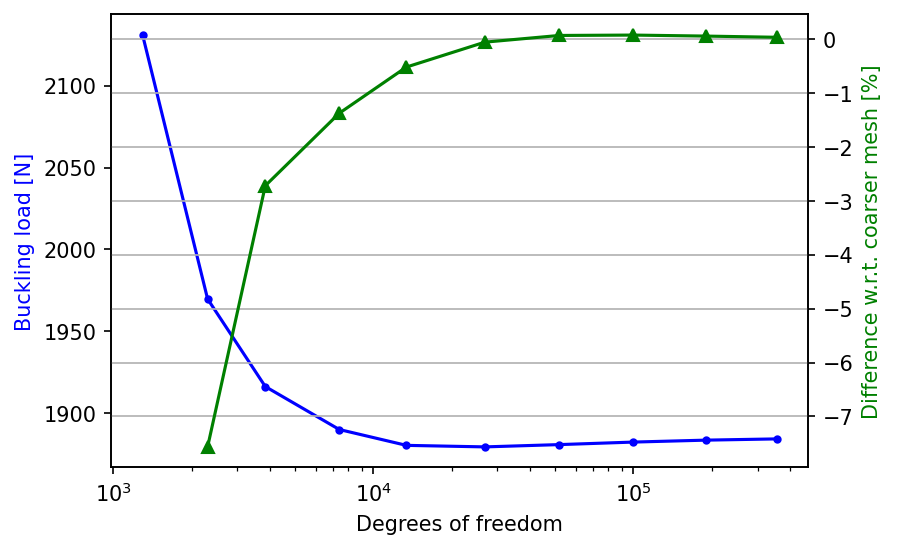

In [9]:
# Plot degrees of freedom vs buckling loads with a log scale along the x-axis
plt.semilogx(dofs, linear_buckling_loads, 'b.-')
# Add second y-axis on the right of the plot
ax1 = plt.gca()
ax2 = ax1.twinx()
# Calculate the percentage difference of each buckling load with respect to the one obtained with the coareser mesh
percentage_diff = (linear_buckling_loads[1:]/linear_buckling_loads[0:-1]-1)*100
# Plot degrees of freedom vs the percentage difference
ax2.plot(dofs[1:], percentage_diff, 'g^-')
# Set the axes label and the grid
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load [N]', color='b')
ax2.set_ylabel('Difference w.r.t. coarser mesh [%]', color='g')
plt.grid()
plt.show()

We see that the buckling load makes a big jump from the first to the third linear size of the shell elements and then assumes a monothonic behavior. The initial behavior can be probably ascribed to the poor resolution of the mesh that results in a stiffening of the structure. After such initial behavior, the buckling load appears to converge to a value just below 4000 N. We define the mesh to be converged when the percentage difference of the buckling loads falls below 1%.

In [10]:
converged_mesh_index = np.where(np.abs(percentage_diff)<1)[0][1]+1
converged_edge_length = shell_element_edges[converged_mesh_index]
linear_buckling_load = linear_buckling_loads[converged_mesh_index]
print(f'The mesh is converged for an approximate shell element edge of {converged_edge_length:.1f} mm, corresponidng to {dofs[converged_mesh_index]:.0f} degrees of freedom and to a linear buckling load of {linear_buckling_load:.0f} N.')

The mesh is converged for an approximate shell element edge of 53.0 mm, corresponidng to 26832 degrees of freedom and to a linear buckling load of 1879 N.


### Nonlinear buckling method <a name="disrtibuted-load-flexible-tip"></a>

Now we want to analyze the buckling behavior of our box beam with SOL 106's nonlinear buckling method. We already explained and used this method for the calculation of the [buckling load of Euler's column](01_Buckling_Analysis_Euler_Column.ipynb). Here we want to investigate how the buckling load and shape change for different magnitudes of the applied load. In order to do this, we are going to define a sequence of subcases with increasing applied loads, calculating for each the buckling load and shape.

Let's create the base bdf input for our nonlinear analysis using the shell element edge length reported earlier and let's apply a distributed load. Then we define a function to set up and run the nonlinear analysis with the nonlinear buckling method in an analogous way as we did for the [Euler's column](01_Buckling_Analysis_Euler_Column.ipynb). The nonlinear analysis is set up to run through different subcases with increasing applied loads.

In [ ]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran
from pyNastran.op2.op2 import read_op2  # function to read the op2 output of Nastran

# Create base bdf input
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=converged_edge_length)
nonlinear_buckling_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Apply uniform load
apply_distributed_load(nonlinear_buckling_input, nodes_coordinates_array)

def apply_nonlinear_buckling_method(bdf_input, load_magnitudes, input_filename, run_flag=True):
    # Assign solution sequence
    bdf_input.sol = 106
    # Add parameter for large displacement effects
    bdf_input.add_param('LGDISP', [1])
    # Define general parameters for the nonlinear iteration strategy
    nlparm_id = 1
    bdf_input.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)
    # Define parameters for the arc-length method
    bdf_input.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=1000)
    # Add NLPARM id to the control case commands
    bdf_input.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)
    # Parameters for buckling analysis
    bdf_input.add_param('BUCKLE', [2])
    eigrl_set_id = force_set_id+1
    bdf_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)
    bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)
    # Create the LOAD cards and the associated subcases
    for i, scale_factor in enumerate(load_magnitudes):
        load_set_id = 21+i
        bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
        pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=i+1, load_set_id=load_set_id)
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, bdf_filename=input_filename, run_flag=run_flag)
    # Read op2 file
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=False)
    # Return op2 object
    return op2_output

We define 4 different subcases with increasing applied loads. These are evenly spaced between 1 N and the linear buckling load predicted by SOL 105, so about 3824 N. We consider only 1 N for the first subcase because we want to verify the behavior of SOL 106's nonlinear buckling method when the structure is deformed only slightly and thus it is very close to its undeformed state. For such situation, we expect SOL 106 to predict a buckling load very close to the one predicted by SOL 105.

In [ ]:
# Define magnitudes of applied load and print them
load_magnitudes = np.linspace(1, linear_buckling_load, 4)
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {load_magnitudes}')

We can now run the analysis and read the output file. For each applied load we calculate the buckling load with SOL 106's nonlinear buckling method.

In [ ]:
input_filename = 'distributed_load_flexible_tip_nonlinear_buckling_method'
op2_output = apply_nonlinear_buckling_method(nonlinear_buckling_input, load_magnitudes, input_filename, run_flag=True)

We then plot the applied load $P$ versus the buckling load predicted by SOL 106 $P_{SOL 106}$ and the critical buckling factor $\alpha$. All loads are nondimensionalized with the buckling load predicted by SOL 105 $P_{SOL 105}$.

In [ ]:
def plot_buckling_loads(applied_loads, sol105_buckling_load, sol106_buckling_loads, alphas):
    # Create figure with subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex='all')
    # Plot applied loads vs buckling loads
    axs[0].plot(applied_loads/sol105_buckling_load, sol106_buckling_loads/sol105_buckling_load, '.-')
    # Plot applied loads vs critical buckling factors
    axs[1].plot(applied_loads/sol105_buckling_load, alphas, '.-')
    reference, = axs[1].plot(applied_loads/sol105_buckling_load, [1]*len(applied_loads), '--k', label='$\\alpha=1$')
    # Set plot appearance
    axs[0].set_ylabel('$P_{SOL 106}/P_{SOL 105}$')
    axs[0].grid(visible=True)
    axs[1].set_ylabel('ALPHA')
    axs[1].grid(visible=True)
    axs[1].legend(handles=[reference])
    axs[1].set_xlabel('$P/P_{SOL 105}$')
    axs[1].set_ylim([0, 60])
    # Show plot
    plt.show()

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)
# Plot results
plot_buckling_loads(load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

Finally, we also plot the nonlinear deformation of the structure and the predicted buckling shape for each subcase.

In [ ]:
# Iterate through the valid subcases found in the op2 file and plot displacements and buckling shape
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]
for count, applied_load in enumerate(load_magnitudes):
    print(f'Applied load: {applied_load:.0f} N\nPredicted buckling load: {nonlinear_buckling_loads[count]:.0f}\nNonlinear deformation:')
    pynastran_utils.plot_displacements(op2_object=op2_output, subcase=valid_displacements_keys[count])
    print(f'Buckling shape:')
    pynastran_utils.plot_buckling_shape(op2_object=op2_output, subcase=eigenvector_keys[count])

Some observation can be made looking at the results.
- The nonlinear buckling load appears to have a linear relationship with the applied load and does not seem to converge to a certain value.
- The nonlinear buckling load for an applied load of 1 N is considerably smaller than the linear buckling load. This is in contrast to our expectations, because, given its small deformation, the structure is very close to its undeformed state. As a consequence, it would be reasonable to expect a buckling behavior similar to the one predicted by the linear analysis, which accounts only for the undeformed state of the structure. It is unclear why this happens, so further investigation is needed.
- The displacement field obtained from the nonlinear analysis is analogous for all applied loads and presents a peak of the displacement magnitude at the tip of the top skin. Since there is no rib to reinforce the sections of the box beam, the skin results relatively flexible and gets pulled out-of-plane by the distributed load. This behavior is evidently different from a classic global beam-like deformation where the sections of the beam stay substantially undeformed. The magnitude of the displacement peak suggests a linear behavior of the structure for the range of applied loads investigated.
- Despite the analogous displacement fields, the first buckling shape appears to change with the magnitude of the applied load. For smaller load magnitudes the first buckling shape affects the tip of the box beam, while for larger load magnitudes the displacement peak is located more inboard, resembling sligthly more the shape predicted by the linear buckling analysis. As a consequence, it appears that for small loads the buckling shape is more influenced by the local displacement of the top skin at the tip of the box beam, while for large loads the buckling shape is less influenced by that and resembles more the shape that would be expected for a structure having a global beam-like behavior.

It is possible that the nonlinear deformation acts like an imperfection that breaks the bifurcation point corresponding to the critical buckling load. If this is the case, it is necessary to understand what the eigenvalues calculated by SOL 106 represent.

### Rigid tip section <a name="distributed-load-rigid-tip"></a>

Let's try now to limit the out-of-plane displacement of the top skin observed at the tip for the previous nonlinear analyses. We are going to constrain the tip section of the box beam in order to make it rigid, keeping the same type of distributed load employed earlier.

We define a new base `BDF` object and we add a master node at the center of the tip section. We then add a RBE2 element that constrains all the nodes along the section of the tip to the master node, making the section rigid.

In [ ]:
# Copy base bdf input
rigid_tip_section_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
apply_distributed_load(rigid_tip_section_input, nodes_coordinates_array)
# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
rigid_tip_section_input.add_grid(master_node_id, [w/2, b, 0.])
# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]
rbe2_eid = len(rigid_tip_section_input.elements) + 1
rigid_tip_section_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)

We run a linear buckling analysis to check for any change in the buckling load and shape with respect to the configuration with a free tip section.

In [ ]:
# Calculate linear buckling load and plot shape
linear_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=rigid_tip_section_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='distributed_load_rigid_tip_linear_buckling', run_flag=True, plot_shape=True)

We can observe how both the buckling load and the buckling shape do not change with respect to the free tip configuration. The reason for this has to be found in the fact that the linear buckling analysis considers the structure in its undeformed state only and as a consequence it is not able to catch any difference between a free and a rigid tip section.

Now we switch to the nonlinear buckling analysis and we apply the same loads that we used for the free tip configuration.

In [ ]:
# Set up and run analysis
input_filename = 'distributed_load_rigid_tip_nonlinear_buckling_method'
op2_output = apply_nonlinear_buckling_method(rigid_tip_section_input, load_magnitudes, input_filename, run_flag=True)
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)
# Plot results
plot_buckling_loads(load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)
# Iterate through the valid subcases found in the op2 file and plot displacements and buckling shape
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]
for count, applied_load in enumerate(load_magnitudes):
    print(f'Applied load: {applied_load:.0f} N\nPredicted buckling load: {nonlinear_buckling_loads[count]:.0f}\nNonlinear deformation:')
    pynastran_utils.plot_displacements(op2_object=op2_output, subcase=valid_displacements_keys[count])
    print(f'Buckling shape:')
    pynastran_utils.plot_buckling_shape(op2_object=op2_output, subcase=eigenvector_keys[count])

Looking at the nonlinear deformation plots, we can observe that with the rigid tip section, the displacement pick has moved sligthly more inboard with respect to what we found for the free tip configuration. In fact, if on one hand the rigid tip section eliminates the out-of-plane displacement of the top skin at the very tip of the box beam, we can still observe such behavior almost all over the span. Clearly, more rigid sections or the introduction of some ribs are needed to obtain a displacement field resembling a global beam-like kind of deformation.

Nevertheless, the presence of the rigid tip section seems to have a substantial effect on the buckling shape. In fact, there is no local buckling mode at the tip for small loads, in contrast to what was found for the free section configuration. The displacement peak is located approximately at the center of the box beam along the span for an applied load of 1 N, while it moves more towards the root for larger loads. The buckling shape for large loads is similar to the one obtained with the free tip configuration. As a consequence it can be stated that the rigid tip section has a substantial influence only on the buckling behavior only for small applied loads.

As far as the magnitude of the buckling loads is concerned, analogous results with respect to the free tip configuration are found also here.

## Concentrated load at the tip <a name="concentrated-load"></a>

***

Now we are going to change the type of load applied on our box beam. Instead of a distributed load over the top skin, we are going to load the structure with a concentrated force applied at the center of the tip section. We are going to investigate the response to this load with both a free and a rigid tip section.

In [ ]:
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

### Flexible tip section <a name="concentrated-load-flexible-tip"></a>
Let's start with applying the concetrated load to a box beam with a free tip section. Similarly to the previous case with a rigid section, we create a base `BDF` object and we add a master node at the center of the tip section. This time we add a RBE3 element to connect the nodes of the section to the master node. This element allows us to introduce a force at the master node and to distribute it to the nodes of the tip section, where the motion of the master node is defined as a weighted average of the motions of the connected nodes. Finally, we add a concentrated upward force of 1 N at the master node using a FORCE card.

In [ ]:
# Generate a base bdf input
concentrated_load_flexible_tip_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Add master node of tip section
concentrated_load_flexible_tip_input.add_grid(master_node_id, [w/2, b, 0.])
# Add RBE3 element to apply concentrated load at the master node
rbe3_eid = rbe2_eid
concentrated_load_flexible_tip_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_nodes_ids), comps=['123456']*len(tip_nodes_ids), Gijs=tip_nodes_ids)
# Add concentrated force
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
concentrated_load_flexible_tip_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

Once again we first calculate the linear buckling load and the corresponding shape.

In [ ]:
# Calculate linear buckling load and plot shape
linear_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=concentrated_load_flexible_tip_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='concentrated_load_flexible_tip_linear_buckling', run_flag=True, plot_shape=True)

The predicted buckling shape is similar to the one of the case with a distributed load. The buckling load results smaller, as expected. In fact, since the force is only applied at the tip of the box beam, the effective moment arm with respect to the root is larger than the one of the distributed load case. As a consequence, a smaller force is needed to induce buckling in the structure.

Once again we run our nonlinear analyses applying 4 different load magnitudes, this time evenly distributed between 1 N and 1600 N.

In [ ]:
# Define magnitudes of applied load and print them
load_magnitudes = np.linspace(1, linear_buckling_load, 4)
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {load_magnitudes}')
# Set up and run analysis
input_filename = 'concentrated_load_flexible_tip_nonlinear_buckling_method'
op2_output = apply_nonlinear_buckling_method(concentrated_load_flexible_tip_input, load_magnitudes, input_filename, run_flag=True)
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)
# Plot results
plot_buckling_loads(load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)
# Iterate through the valid subcases found in the op2 file and plot displacements and buckling shape
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]
for count, applied_load in enumerate(load_magnitudes):
    print(f'Applied load: {applied_load:.0f} N\nPredicted buckling load: {nonlinear_buckling_loads[count]:.0f}\nNonlinear deformation:')
    pynastran_utils.plot_displacements(op2_object=op2_output, subcase=valid_displacements_keys[count])
    print(f'Buckling shape:')
    pynastran_utils.plot_buckling_shape(op2_object=op2_output, subcase=eigenvector_keys[count])

Also for this investigation, the displacement field obtained from the nonlinear static analyses is analogous for all load magnitudes. However, the displacement does not appear to be distributed all along the span of the box beam, rather it is concentrated in the region of the tip. As expected, the displacement peak is located at the center of the skin, given the flexibility caused by the free section. A small nonlinearity can be noted looking at the change of the magnitude of the displacement peak with the different applied loads.

The effect of the locally-dominated nonlinear displacement field can be clearly seen on the buckling shape. In fact, the buckling deformation is extremely localized at the tip of the box beam. Only for the case with the largest load magnitude, the buckling shape is very similar to the one predicted by the linear analysis, so closer to a structure having a global beam-like behavior. This seems to confirm the fact that the local deformation at the tip of the box beam has a different influence on the buckling behavior according to the level of applied load.

Once again we notice that the nonlinear analysis predicts buckling loads linearly dependent from the applied loads, except for the largest applied load, where the linearity seems to break. However, the predicted buckling loads do not show a clear convergence towards a certain value. Furthermore, the buckling load obtained with an applied load of 1 N is again the farthest value from the linear buckling load, which is not what is expected.

### Rigid tip section  <a name="concentrated-load-rigid-tip"></a>
Finally, we want to test the concentrated load with a rigid tip section. Analogously to the previous cases, we generate a base `BDF` object, add a master node at the center of the tip section, add an RBE2 element to constrain the section and add a concentrated load at the master node with a FORCE card. We then calculate the linear buckling load with the associated shape.

In [ ]:
# Generate a base bdf input
concentrated_load_rigid_tip_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Add master node of tip section
concentrated_load_rigid_tip_input.add_grid(master_node_id, [w/2, b, 0.])
# Add RBE2 element to make tip section rigid
concentrated_load_rigid_tip_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)
# Add concentrated force to rigid tip section input
concentrated_load_rigid_tip_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)
# Calculate linear buckling load and plot shape
linear_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=concentrated_load_rigid_tip_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='concentrated_load_rigid_tip_linear_buckling', run_flag=True, plot_shape=True)

Also in this case we do not notice any difference in terms of buckling load and shape with respect to the free tip configuration, as expected.

We now run our nonlinear analyses in an analogous way as for the previous case.

In [ ]:
# Set up and run analysis
input_filename = 'concentrated_load_rigid_tip_nonlinear_buckling_method'
op2_output = apply_nonlinear_buckling_method(concentrated_load_rigid_tip_input, load_magnitudes, input_filename, run_flag=True)
# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)
# Plot results
plot_buckling_loads(load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)
# Iterate through the valid subcases found in the op2 file and plot displacements and buckling shape
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]
for count, applied_load in enumerate(load_magnitudes):
    print(f'Applied load: {applied_load:.0f} N\nPredicted buckling load: {nonlinear_buckling_loads[count]:.0f}\nNonlinear deformation:')
    pynastran_utils.plot_displacements(op2_object=op2_output, subcase=valid_displacements_keys[count])
    print(f'Buckling shape:')
    pynastran_utils.plot_buckling_shape(op2_object=op2_output, subcase=eigenvector_keys[count])

In this case we can observe a global beam-like behavior for both the nonlinear deformation and the buckling shape. The displacement field of the nonlinear deformation is distributed from the root to the tip of the box beam for all the applied loads. Furthermore, the structure appears to have a linear response looking at the displacement peaks for the range of loads investigated. The buckling shape resembles closely the one predicted by the linear analysis for all the analyses. As far as the buckling loads are concerned, all values predicted by the nonlinear analysis are closer to the one predicted by the linear analysis but also here there is no clear convergence to a certain value.

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()